In [10]:
import warnings
import numpy as np
import pandas as pd

import os

In [11]:
df = pd.read_csv("archive/train.txt",sep=";",
    names=["Description","Emotion"])
df.head(5)

,Description,Emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [12]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16000 entries, 0 to 15999
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Description  16000 non-null  object
 1   Emotion      16000 non-null  object
dtypes: object(2)
memory usage: 250.1+ KB
None


In [13]:
df['Emotion'].value_counts()

Emotion
joy         5362
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: count, dtype: int64

In [14]:
df['label_num'] = df['Emotion'].map({
    'joy' : 0, 
    'sadness': 1, 
    'anger': 2, 
    'fear': 3,
    'love': 4,
    'surprise':5
})

df.head(5)

,Description,Emotion,label_num
0,i didnt feel humiliated,sadness,1
1,i can go from feeling so hopeless to so damned...,sadness,1
2,im grabbing a minute to post i feel greedy wrong,anger,2
3,i am ever feeling nostalgic about the fireplac...,love,4
4,i am feeling grouchy,anger,2


In [15]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(df.Description,df.label_num,test_size=0.2)

In [16]:
import spacy
nlp = spacy.load("en_core_web_sm")

In [17]:
def preprocess(text):
    doc = nlp(text)
    filtered_tokens = []
    for token in doc:
        if token.is_stop or token.is_punct:
            continue
        else:
            filtered_tokens.append(token.lemma_)
    return " ".join(filtered_tokens)

In [18]:
df['processed_text'] = df["Description"].apply(preprocess)

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report


clf = Pipeline([
     ('vectorizer_tfidf',TfidfVectorizer()), 
     ('Random Forest', RandomForestClassifier())         
])

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
y_pred_rf = clf.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.94      0.88      1134
           1       0.93      0.88      0.90       923
           2       0.85      0.84      0.85       393
           3       0.83      0.74      0.78       383
           4       0.84      0.62      0.71       253
           5       0.78      0.68      0.73       114

    accuracy                           0.85      3200
   macro avg       0.84      0.78      0.81      3200
weighted avg       0.86      0.85      0.85      3200



In [20]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
cm

array([[1070,   20,   10,    7,   22,    5],
       [  61,  811,   26,   18,    6,    1],
       [  34,   22,  331,    6,    0,    0],
       [  47,   15,   18,  285,    2,   16],
       [  86,    6,    2,    3,  156,    0],
       [   9,    0,    1,   26,    0,   78]])

Text(95.72222222222221, 0.5, 'Truth')

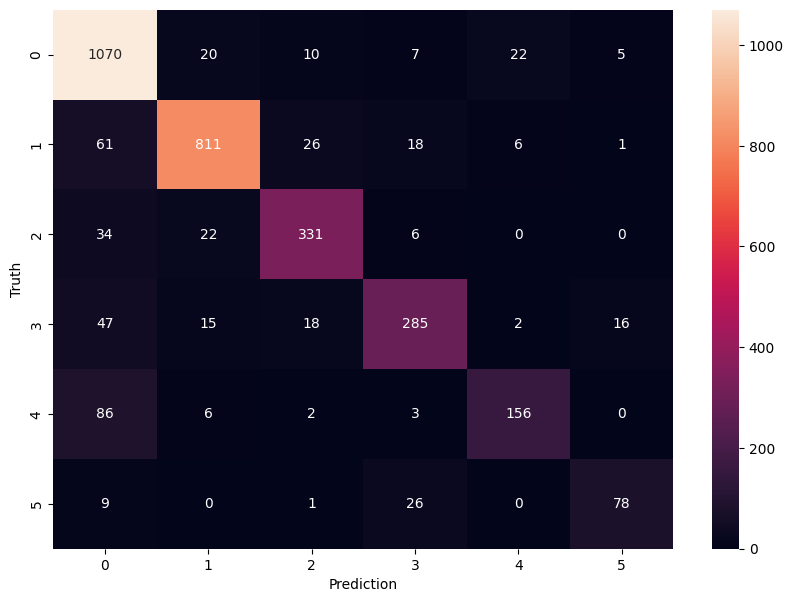

In [21]:
from matplotlib import pyplot as plt
import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Prediction')
plt.ylabel('Truth')

In [22]:
import whisper
import sounddevice as sd
import numpy as np
from pydub import AudioSegment

def record_audio(duration, samplerate=44100):
    print("Recording...")
    audio_data = sd.rec(int(samplerate * duration), samplerate=samplerate, channels=1, dtype='int16')
    sd.wait()
    print("Recording complete.")
    return audio_data.flatten()

def save_audio_mp3(data, filename='collection/output.mp3', samplerate=44100):
    print(f"Saving audio to {filename}...")
    # Normalize the audio data to the range [-1, 1]
    normalized_data = data / np.max(np.abs(data), axis=0)
    # Convert to 16-bit PCM format
    pcm_data = (normalized_data * 32767).astype(np.int16)
    # Create an AudioSegment from the PCM data
    audio_segment = AudioSegment(pcm_data.tobytes(), frame_rate=samplerate, sample_width=2, channels=1)
    # Export as MP3
    audio_segment.export(filename, format="mp3")
    print("Audio saved.")

def transcribe():
    model = whisper.load_model("base")
    result = model.transcribe("collection/output.mp3")
    return result

In [25]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline


X = df['processed_text']
y = df['label_num']

clf = Pipeline([
    ('vectorizer_tfidf', TfidfVectorizer()),
    ('Random Forest', RandomForestClassifier())
])

clf.fit(X, y)

def predict_emotion(sentence):
    processed_sentence = preprocess(sentence)

    emotion_label = clf.predict([processed_sentence])[0]
    emotion_mapping = {0: 'joy', 1: 'sadness', 2: 'anger', 3: 'fear', 4: 'love', 5: 'surprise'}
    predicted_emotion = emotion_mapping[emotion_label]

    return predicted_emotion

def get_user_input():
    duration = int(input("put the length of your speech in seconds (e.g. 5): "))
    audio_data = record_audio(duration)
    save_audio_mp3(audio_data)
    text = transcribe()
    return str(text['text'])
    

user_input = get_user_input()
predicted_emotion = predict_emotion(user_input)
print(user_input)
print(f"The predicted emotion for the sentence is: {predicted_emotion}")
#i was ready to meet mom in the airport and feel her ever supportive arms around me;

Recording...
Recording complete.
Saving audio to collection/output.mp3...
Audio saved.


/Users/sanekng/Documents/SpeakUp/venv/lib/python3.11/site-packages/whisper/transcribe.py:115: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


 Hello, I'm feeling fine today, the project is finished and I'm happy about it.
The predicted emotion for the sentence is: joy
